<h1> Bike theft in Berlin 2023-2024</>

README

Data was from https://daten.berlin.de/datensaetze/fahrraddiebstahl-in-berlin

Based on police statistics (data warehouse management information), daily updated data on bicycle theft crimes is made available at the planning area level. This includes the data for the current year up to the day before the update, as well as the data for the entire previous year, provided that the time of the crime (for crime periods) can be narrowed down to a maximum of three days.

Column descriptions in English:

ANGELEGT_AM: date when the police report was reported and created
TATZEIT_ANFANG_DATUM: start date of the incident 
TATZEIT_ANFANG_STUNDE: start hour of the incident
TATZEIT_ENDE_DATUM: end date of the incident
TATZEIT_ENDE_STUNDE: end hour of the incident
LOR: place of incident, this is the city postal code
SCHADENSHOEHE: amount of damages, cost of the bike plus other accessories like bike lock, etc
VERSUCH: attempt
ART_DES_FAHRRADS: type of bike
DELIKT: crime / offense (ie. bike theft)
ERFASSUNGSGRUND: reason for report

Some guide questions for exploring this data:

Which month have the highest incidents?
What day of the week does the incident occur?
Average cost of the damages?
Where does the incident happen?
Types of bikes that stolen?
For the hours, start and end time are available -- calculate average timeframe (ie. 19 to 22) per month when the incident happened

In [1]:
import pandas as pd
pd.options.mode.chained_assignment = None

import numpy as np
import seaborn as sns
import matplotlib.pyplot as plt
import plotly.graph_objects as go
import plotly.express as px

import warnings
warnings.filterwarnings('ignore')

In [2]:
#Read CSV

berlin_bike_df = pd.read_csv('../data/bike_theft_berlin.csv',
                encoding = "ISO-8859-1", 
                dtype={                       
                        'LOR':'string',
                        'VERSUCH':'string',
                        'ART_DES_FAHRRADS':'string',
                        'DELIKT':'string',
                        'ERFASSUNGSGRUND':'string'
                   },                   
                parse_dates=["ANGELEGT_AM", "TATZEIT_ANFANG_DATUM", "TATZEIT_ENDE_DATUM"], 
                date_format = '%d.%m.%Y')

<h3> Data check </>

In [3]:
berlin_bike_df.head()

,ANGELEGT_AM,TATZEIT_ANFANG_DATUM,TATZEIT_ANFANG_STUNDE,TATZEIT_ENDE_DATUM,TATZEIT_ENDE_STUNDE,LOR,SCHADENSHOEHE,VERSUCH,ART_DES_FAHRRADS,DELIKT,ERFASSUNGSGRUND
0,2024-12-06,2024-12-05,19,2024-12-05,21,04300623,3000,Nein,Herrenfahrrad,Fahrraddiebstahl,Sonstiger schwerer Diebstahl von Fahrrädern
1,2024-12-06,2024-12-05,14,2024-12-05,20,02500835,599,Nein,Damenfahrrad,Fahrraddiebstahl,Sonstiger schwerer Diebstahl von Fahrrädern
2,2024-12-06,2024-12-05,12,2024-12-05,15,04501153,929,Nein,Herrenfahrrad,Fahrraddiebstahl,Sonstiger schwerer Diebstahl von Fahrrädern
3,2024-12-06,2024-12-05,19,2024-12-06,12,11100206,1400,Nein,Fahrrad,Fahrraddiebstahl,Sonstiger schwerer Diebstahl von Fahrrädern
4,2024-12-06,2024-12-06,15,2024-12-06,15,01100416,500,Nein,Fahrrad,Fahrraddiebstahl,Sonstiger schwerer Diebstahl von Fahrrädern


In [4]:
berlin_bike_df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 41723 entries, 0 to 41722
Data columns (total 11 columns):
 #   Column                 Non-Null Count  Dtype         
---  ------                 --------------  -----         
 0   ANGELEGT_AM            41723 non-null  datetime64[ns]
 1   TATZEIT_ANFANG_DATUM   41723 non-null  datetime64[ns]
 2   TATZEIT_ANFANG_STUNDE  41723 non-null  int64         
 3   TATZEIT_ENDE_DATUM     41723 non-null  datetime64[ns]
 4   TATZEIT_ENDE_STUNDE    41723 non-null  int64         
 5   LOR                    41723 non-null  string        
 6   SCHADENSHOEHE          41723 non-null  int64         
 7   VERSUCH                41723 non-null  string        
 8   ART_DES_FAHRRADS       41723 non-null  string        
 9   DELIKT                 41723 non-null  string        
 10  ERFASSUNGSGRUND        41723 non-null  string        
dtypes: datetime64[ns](3), int64(3), string(5)
memory usage: 3.5 MB


In [129]:
berlin_bike_df['TATZEIT_ANFANG_STUNDE'].unique()

array([19, 14, 12, 15, 20, 11, 16,  7, 22, 18, 21, 10, 23,  3,  9,  8, 17,
        0,  4,  5,  2, 13,  6,  1])

In [139]:
berlin_bike_df['SCHADENSHOEHE'].describe()

count    41723.000000
mean      1209.958728
std       1187.909895
min          0.000000
25%        498.000000
50%        820.000000
75%       1499.000000
max      10000.000000
Name: SCHADENSHOEHE, dtype: float64

In [117]:
berlin_bike_df['ERFASSUNGSGRUND'].unique()

<StringArray>
[                    'Sonstiger schwerer Diebstahl von Fahrrädern',
                              'Einfacher Diebstahl von Fahrrädern',
 'Sonstiger schwerer Diebstahl in/aus Keller/Boden von Fahrrädern',
             'Einfacher Diebstahl aus Keller/Boden von Fahrrädern']
Length: 4, dtype: string

In [121]:
berlin_bike_df['DELIKT'].unique()

<StringArray>
['Fahrraddiebstahl', 'Keller- und Bodeneinbruch']
Length: 2, dtype: string

In [119]:
berlin_bike_df['DELIKT'].value_counts()

DELIKT
Fahrraddiebstahl             39297
Keller- und Bodeneinbruch     2426
Name: count, dtype: Int64

In [120]:
berlin_bike_df['VERSUCH'].unique()

<StringArray>
['Nein', 'Unbekannt', 'Ja']
Length: 3, dtype: string

In [210]:
berlin_bike_df['VERSUCH'].value_counts()

VERSUCH
Nein         41535
Ja             178
Unbekannt       10
Name: count, dtype: Int64

<h4> Drop the Ja (only attempt was made) and Unbekannt (unclear whether it was stolen or not), then drop the column entirely</>

In [18]:
berlin_bike_df['ART_DES_FAHRRADS'].unique()

<StringArray>
[    'Herrenfahrrad',      'Damenfahrrad',           'Fahrrad',
           'Rennrad',      'Mountainbike', 'diverse Fahrräder',
     'Lastenfahrrad',     'Kinderfahrrad']
Length: 8, dtype: string

In [116]:
type_bike = berlin_bike_df['ART_DES_FAHRRADS'].value_counts().reset_index()
type_bike

,ART_DES_FAHRRADS,count
0,Herrenfahrrad,18854
1,Damenfahrrad,10732
2,Fahrrad,6631
3,Kinderfahrrad,1700
4,Mountainbike,1643
5,diverse Fahrräder,1182
6,Rennrad,821
7,Lastenfahrrad,160


In [21]:
berlin_bike_df.columns

Index(['ANGELEGT_AM', 'TATZEIT_ANFANG_DATUM', 'TATZEIT_ANFANG_STUNDE',
       'TATZEIT_ENDE_DATUM', 'TATZEIT_ENDE_STUNDE', 'LOR', 'SCHADENSHOEHE',
       'VERSUCH', 'ART_DES_FAHRRADS', 'DELIKT', 'ERFASSUNGSGRUND'],
      dtype='object')

<h3> Date and time cleaning </>

In [237]:
## Creating new column for month-year
berlin_bike_df['incident_month_year'] = berlin_bike_df['TATZEIT_ANFANG_DATUM'].dt.to_period('M')

## Creating new column for incident year only
berlin_bike_df['incident_year'] = berlin_bike_df['TATZEIT_ANFANG_DATUM'].dt.year

## Creating new column for incident month only
berlin_bike_df['incident_month'] = berlin_bike_df['TATZEIT_ANFANG_DATUM'].dt.month

## Reported year (accidentally added, is now dropped)
## berlin_bike_df['year'] = berlin_bike_df['ANGELEGT_AM'].dt.year

## Creating new column for day of the week
berlin_bike_df['day_of_week'] = berlin_bike_df['TATZEIT_ANFANG_DATUM'].dt.day_name()

berlin_bike_df.head(3)

,ANGELEGT_AM,TATZEIT_ANFANG_DATUM,TATZEIT_ANFANG_STUNDE,TATZEIT_ENDE_DATUM,TATZEIT_ENDE_STUNDE,LOR,SCHADENSHOEHE,VERSUCH,ART_DES_FAHRRADS,DELIKT,ERFASSUNGSGRUND,incident_month_year,incident_year,incident_month,day_of_week
0,2024-12-06,2024-12-05,19,2024-12-05,21,04300623,3000,Nein,Herrenfahrrad,Fahrraddiebstahl,Sonstiger schwerer Diebstahl von Fahrrädern,2024-12,2024,12,Thursday
1,2024-12-06,2024-12-05,14,2024-12-05,20,02500835,599,Nein,Damenfahrrad,Fahrraddiebstahl,Sonstiger schwerer Diebstahl von Fahrrädern,2024-12,2024,12,Thursday
2,2024-12-06,2024-12-05,12,2024-12-05,15,04501153,929,Nein,Herrenfahrrad,Fahrraddiebstahl,Sonstiger schwerer Diebstahl von Fahrrädern,2024-12,2024,12,Thursday


<h3> Drop columns and rows</>

<h4> Delikt, Erfassungsgrund, Versuch columns can be dropped</>

In [ ]:
## Drop Ja & Unbekannt in Versuch column. Versuch means attempted and Ja means it was not stolen and Unbekannt means it's unclear 

copy_ber_bike_df = berlin_bike_df.drop(berlin_bike_df[berlin_bike_df['VERSUCH'].isin(['Ja', 'Unbekannt'])].index, inplace=True)

## copy_ber_bike_df = berlin_bike_df.drop(berlin_bike_df[berlin_bike_df.VERSUCH == 'Unbekannt'].index)
copy_ber_bike_df

In [242]:
berlin_bike_df['VERSUCH'].value_counts()

VERSUCH
Nein    41535
Name: count, dtype: Int64

In [241]:
berlin_bike_df.columns

Index(['ANGELEGT_AM', 'TATZEIT_ANFANG_DATUM', 'TATZEIT_ANFANG_STUNDE',
       'TATZEIT_ENDE_DATUM', 'TATZEIT_ENDE_STUNDE', 'LOR', 'SCHADENSHOEHE',
       'VERSUCH', 'ART_DES_FAHRRADS', 'DELIKT', 'ERFASSUNGSGRUND',
       'incident_month_year', 'incident_year', 'incident_month',
       'day_of_week'],
      dtype='object')

In [243]:
## Create DF copy to drop columns

bikes_df_copy = berlin_bike_df.copy()


In [249]:
bikes_df_copy.drop(columns=['VERSUCH', 'DELIKT', 'ERFASSUNGSGRUND'], inplace=True)

In [251]:
bikes_df_copy.head()

,ANGELEGT_AM,TATZEIT_ANFANG_DATUM,TATZEIT_ANFANG_STUNDE,TATZEIT_ENDE_DATUM,TATZEIT_ENDE_STUNDE,LOR,SCHADENSHOEHE,ART_DES_FAHRRADS,incident_month_year,incident_year,incident_month,day_of_week
0,2024-12-06,2024-12-05,19,2024-12-05,21,04300623,3000,Herrenfahrrad,2024-12,2024,12,Thursday
1,2024-12-06,2024-12-05,14,2024-12-05,20,02500835,599,Damenfahrrad,2024-12,2024,12,Thursday
2,2024-12-06,2024-12-05,12,2024-12-05,15,04501153,929,Herrenfahrrad,2024-12,2024,12,Thursday
3,2024-12-06,2024-12-05,19,2024-12-06,12,11100206,1400,Fahrrad,2024-12,2024,12,Thursday
4,2024-12-06,2024-12-06,15,2024-12-06,15,01100416,500,Fahrrad,2024-12,2024,12,Friday


<H3> Rename Columns to English </>

In [253]:
bikes_df_copy.rename(columns={
    'ANGELEGT_AM': 'created_on', 
    'TATZEIT_ANFANG_DATUM':'incident_start_date',
    'TATZEIT_ANFANG_STUNDE': 'incident_hour_start',
    'TATZEIT_ENDE_DATUM': 'incident_end_date',
    'TATZEIT_ENDE_STUNDE': 'incident_hour_end',
    'LOR': 'lor_id',
    'SCHADENSHOEHE': 'damage_amount',
    'ART_DES_FAHRRADS': 'bicycle_type'}, inplace=True)

In [254]:
bikes_df_copy.head()

,created_on,incident_start_date,incident_hour_start,incident_end_date,incident_hour_end,lor_id,damage_amount,bicycle_type,incident_month_year,incident_year,incident_month,day_of_week
0,2024-12-06,2024-12-05,19,2024-12-05,21,04300623,3000,Herrenfahrrad,2024-12,2024,12,Thursday
1,2024-12-06,2024-12-05,14,2024-12-05,20,02500835,599,Damenfahrrad,2024-12,2024,12,Thursday
2,2024-12-06,2024-12-05,12,2024-12-05,15,04501153,929,Herrenfahrrad,2024-12,2024,12,Thursday
3,2024-12-06,2024-12-05,19,2024-12-06,12,11100206,1400,Fahrrad,2024-12,2024,12,Thursday
4,2024-12-06,2024-12-06,15,2024-12-06,15,01100416,500,Fahrrad,2024-12,2024,12,Friday


<h1> Data exploration </>

<h3> Total incidents for each year </>

In [268]:
## Counting incidents per year
incidents_total = bikes_df_copy['incident_year'].value_counts().reset_index()
incidents_total

,incident_year,count
0,2023,21887
1,2024,19648


<function matplotlib.pyplot.show(close=None, block=None)>

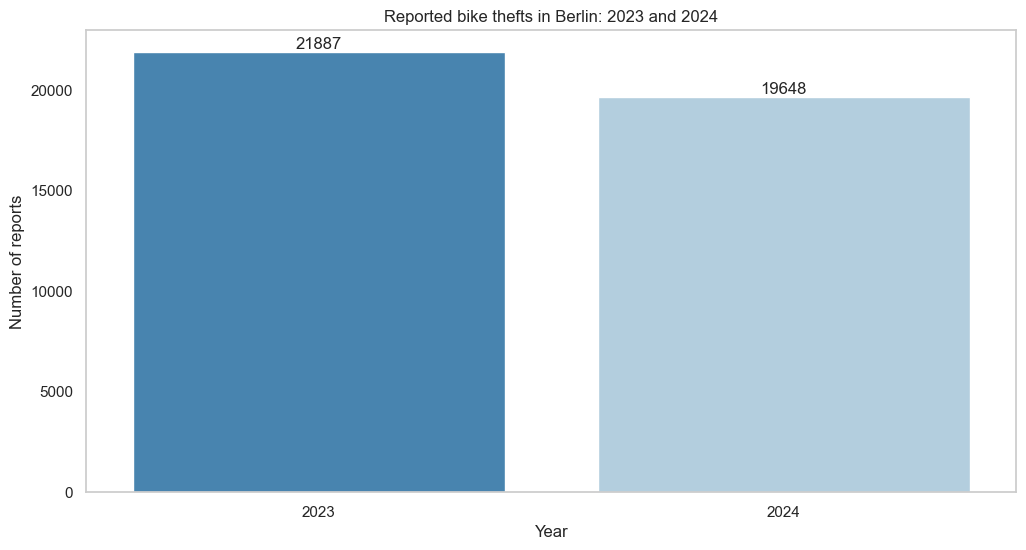

In [278]:
## Bar plot

plt.figure(figsize=(12,6))
ax = sns.barplot(data=incidents_total, x='incident_year', y='count', palette='Blues_r')
for container in ax.containers:
    ax.bar_label(container)

plt.title('Reported bike thefts in Berlin: 2023 and 2024')
plt.xlabel('Year')
plt.ylabel('Number of reports')
plt.grid(False)

#plt.xticks(rotation=90)
plt.show

<h3> Which months have the highest incidents? </>

Compare each month for the 2 years, noting that December 2024 data is incomplete.

In [257]:
## Incidents per month and year

incidents_month_year = bikes_df_copy.groupby(['incident_month','incident_year'])['created_on'].count().reset_index()
## incidents_month_year.rename(columns={"TATZEIT_ANFANG_DATUM": "count"})
incidents_month_year


,incident_month,incident_year,created_on
0,1,2023,1414
1,1,2024,1040
2,2,2023,1333
3,2,2024,1331
4,3,2023,1675
5,3,2024,1641
6,4,2023,1489
7,4,2024,1862
8,5,2023,2220
9,5,2024,2159


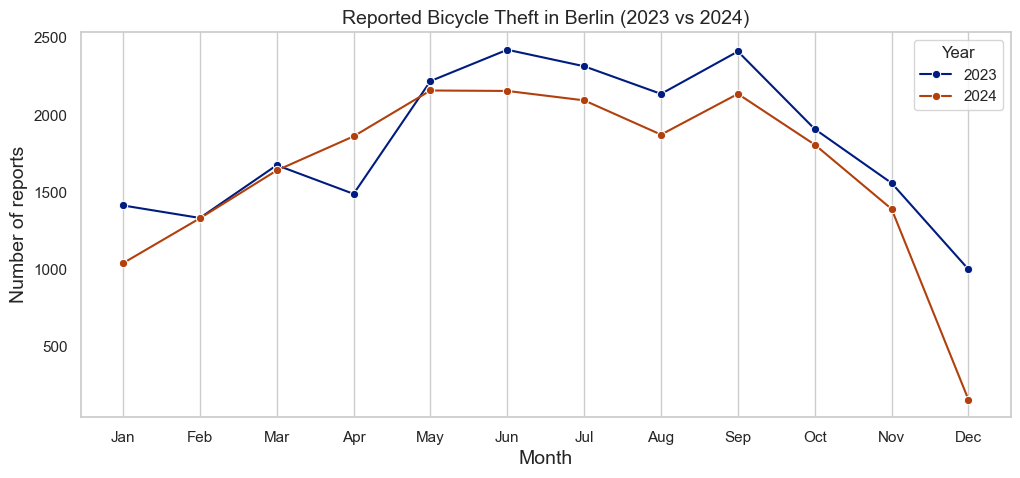

In [279]:
## Create a line plot that compares 2018 and 2019 data per month x=month, y=number of incidents 

# Specify the size of the plot
plt.figure(figsize=(12,5))

# Create the plot
sns.lineplot(x='incident_month', y='created_on', hue='incident_year', 
             data=incidents_month_year, marker='o', palette='dark')

# Labeling x a-xis with actual month instead of numbers 
plt.xticks(ticks=range(1, 13), labels=['Jan', 'Feb', 'Mar', 'Apr', 'May', 'Jun', 'Jul', 'Aug', 'Sep', 'Oct', 'Nov', 'Dec'])

# Add labels to both axis
plt.title('Reported Bicycle Theft in Berlin (2023 vs 2024)', fontsize=14)
plt.xlabel('Month', fontsize=14)
plt.ylabel('Number of reports', fontsize=14)
plt.legend(title='Year')
plt.grid(axis='y')

# Show the plot
plt.show()

In [182]:
## Trying this with bar plot

# Pivot the data for bar plotting
#pivot_monthyear_df = incidents_month_year.pivot(index='incident_month', columns='incident_year', values='TATZEIT_ANFANG_DATUM')

# Plot the grouped bar chart
#pivot_monthyear_df.plot(kind='bar', figsize=(10, 6), width=0.8)
## colors = ['#1E88E5', '#43A047']

# Customize the plot
#plt.title('Monthly Comparison of Incidents (2023 vs 2024)', fontsize=16)
#plt.xlabel('Month', fontsize=14)
#plt.ylabel('Number of Incidents', fontsize=14)
#plt.xticks(ticks=range(0, 12), labels=['Jan', 'Feb', 'Mar', 'Apr', 'May', 'Jun', 
                                       #'Jul', 'Aug', 'Sep', 'Oct', 'Nov', 'Dec'], rotation=0)
#plt.legend(title='Year', fontsize=12)
#plt.grid(axis='y')

# Show the plot
#plt.tight_layout()
#plt.show()

<h3>Which day of the week have highest incidents?</>

In [260]:
## Creating new variable 

incidents_week = bikes_df_copy['day_of_week'].value_counts().reset_index()
incidents_week

,day_of_week,count
0,Friday,6580
1,Wednesday,6287
2,Thursday,6257
3,Monday,6132
4,Tuesday,6097
5,Saturday,5511
6,Sunday,4671


In [261]:
ordered_days = ["Monday", "Tuesday", "Wednesday", "Thursday", "Friday", "Saturday", "Sunday"]
incidents_week["day_of_week"] = pd.Categorical(incidents_week["day_of_week"], categories=ordered_days, ordered=True)
sorted_week = incidents_week.sort_values("day_of_week")

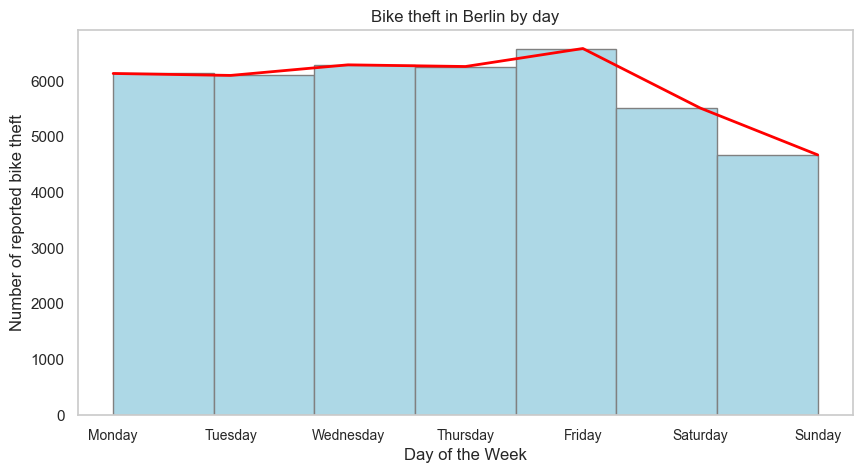

In [305]:
# Plot the histogram
plt.figure(figsize=(10, 5))
plt.hist(sorted_week["day_of_week"], weights=sorted_week["count"], bins=len(sorted_week), color="lightblue", edgecolor="gray")

bar_centers = np.arange(len(sorted_week["day_of_week"]))
plt.plot(bar_centers, sorted_week["count"], color="red", linestyle="-", linewidth=2, label="Trendline")

# Add titles and labels
plt.title("Bike theft in Berlin by day")
plt.xlabel("Day of the Week")
plt.ylabel("Number of reported bike theft")
plt.xticks(fontsize=10)
plt.grid(False)
#plt.tight_layout()

# Show the plot
plt.show()

Should I create a histogram for 2023 only with monthly, weekly stat?

<h3> Average amount of damages </>

In [293]:
bikes_df_copy['damage_amount'].describe()

count    41535.000000
mean      1215.231227
std       1187.892566
min          0.000000
25%        499.000000
50%        828.000000
75%       1500.000000
max      10000.000000
Name: damage_amount, dtype: float64

In [297]:
bikes_df_copy['damage_amount'].mean()

np.float64(1215.2312266762972)

In [300]:
bikes_df_copy['damage_amount'].nsmallest()

60     0
73     0
90     0
120    0
126    0
Name: damage_amount, dtype: int64

In [303]:
bikes_df_copy['damage_amount'].nlargest()

1906    10000
2966    10000
5445    10000
6836    10000
8145    10000
Name: damage_amount, dtype: int64

In [312]:
bikes_df_copy[bikes_df_copy['damage_amount'] >= 3000].count()

created_on             3483
incident_start_date    3483
incident_hour_start    3483
incident_end_date      3483
incident_hour_end      3483
lor_id                 3483
damage_amount          3483
bicycle_type           3483
incident_month_year    3483
incident_year          3483
incident_month         3483
day_of_week            3483
dtype: int64

<function matplotlib.pyplot.show(close=None, block=None)>

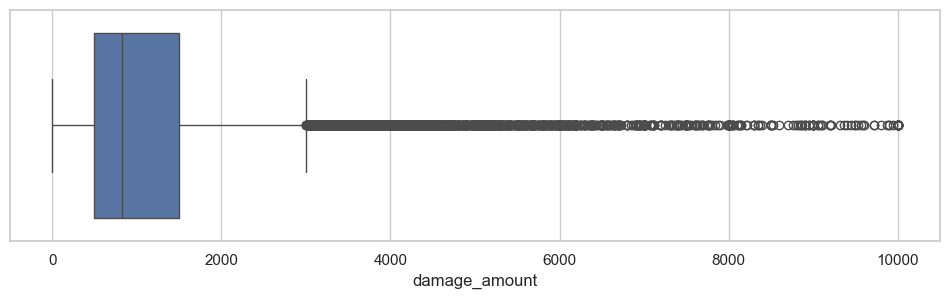

In [299]:
plt.figure(figsize=(12,3))
sns.boxplot(data=bikes_df_copy, x='damage_amount')
plt.show

<function matplotlib.pyplot.show(close=None, block=None)>

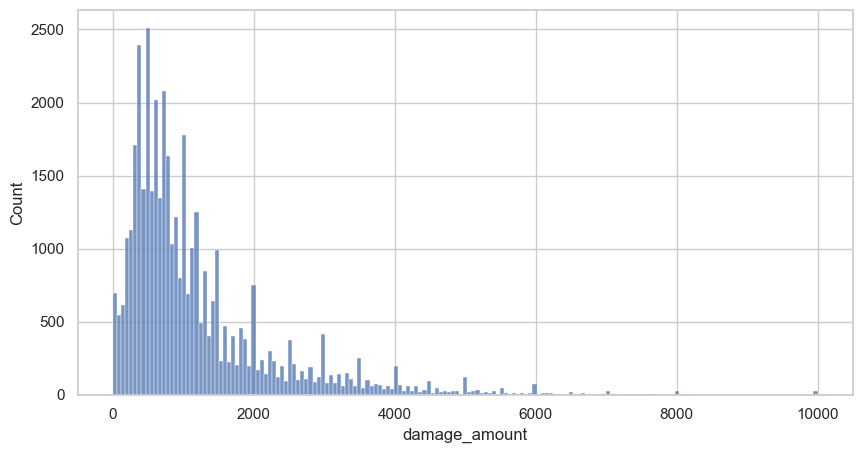

In [ ]:
plt.figure(figsize=(10,5))
sns.histplot(data=bikes_df_copy, x="damage_amount")
plt.show

#kde=True to show the trend line

<h3> Merging LORs from 2 datasets </>

In [ ]:
## READ CSVs

## ber_lor_df = pd.read_csv('/Users/dee/Desktop/DA_Oct24/Final_project/Fahrraddiebstahl/Fahrraddiebstahl.csv',
                ## encoding = "ISO-8859-1")


In [ ]:
## Counting incidents per year per LOR / CITY

##berlin_bike_df.pivot_table(
    #index='LOR', 
    #columns='year', 
    #aggfunc='size', 
    #fill_value=0  # Fill missing values with 0
#)